# MAT2 Monte Carlo and Markov chains

In this document, I'm presenting my solutions to the homework for the third part of the course **Mathematics 2**.

But first let us import the following libraries:

In [1]:
import numpy as np
from math import pi
from scipy import integrate, stats as st
import matplotlib.pyplot as plt
import networkx as nx
import arviz as az
from sklearn.linear_model import LogisticRegression

# %matplotlib qt
# %matplotlib inline

## Exercise 3.6 (More Monte Carlo Integration)

Let $X\sim N(0,1)$ and $f(x)=10e^{−5(x−3)^4}$.

We are interested in computing the expectation of $f$ with respect to  $X$:
$$
E\left[ f\left(X\right) \right] = E\left[ 10e^{−5(X−3)^4} \right] = 
\int_{-\infty}^{\infty}10e^{−5(x−3)^4}\cdot \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}dx \approx 0.0893992.
$$
### a) Approximate  the  integral  using  a  quadrature  based  method 
We Approximated the integral using a quadrature based method using integrate.quad() from scipy.

In [2]:
inf = np.inf
f = lambda x: 10*np.exp(-5*(x-3)**4) * (1/(2*np.pi)**0.5)*np.exp(1)**(-0.5*x**2)
numerical_result = integrate.quad(f, -inf, inf)[0]
print("The approximated integral value using a quadrature based method:", numerical_result)

The approximated integral value using a quadrature based method: 0.08939923794604812


### b) Approximate the integral using Monte Carlo (100 samples).
We Approximated the integral by sampling $100$ samples $x_i$ for $i=1,\dots,100$ from the standard normal distribution, calculated $y_i = f\left( x_i \right)$ and then averaged the results to obtain the approximation:
$$
E\left[f\left(X\right)\right] \approx \sum_{i=1}^{100}y_i = \sum_{i=1}^{100}f\left(x_i\right) = \sum_{i=1}^{100}10e^{−5(x_i−3)^4} = 0.04346. 
$$

In [3]:
def getNSamples(N):
    x_i = np.random.normal(loc=0.0, scale=1.0, size=(N))
    y_i = 10*np.exp(-5*(x_i-3)**4)
    return y_i

np.random.seed(0)
y_i = getNSamples(N=100)
MC100_mean = np.mean(y_i)
MC100_se = np.std(y_i)/10
print("The approximated integral value using Monte Carlo with 100 samples:", MC100_mean)

The approximated integral value using Monte Carlo with 100 samples: 0.043458386846264796


### c) Repeat b) 1000 times.
For each repetition compute a 90% CI using the normal approximation, and observe whether or not the CI contains the 'true' value.

In [4]:
np.random.seed(0)
num_repetitions = 1000
num_samples = 100 # <- INCREASE this to get better results in terms of fraction of CIs containing the 'true' value.
contains_true_counter = 0

z = st.norm.ppf(0.95) # z = 1.64485... for the 90% interval. 
for r in range(num_repetitions):
    y_i = getNSamples(N=num_samples)
    mean = np.mean(y_i)
    se = np.std(y_i)/np.sqrt(num_samples)
    left_bound  = mean - z*se
    right_bound = mean + z*se
    if ( (left_bound <= numerical_result) and (numerical_result <= right_bound ) ):
        contains_true_counter += 1

is_in_CI_frac = contains_true_counter / num_repetitions
print(str(100*is_in_CI_frac)+"% of the confidence intervals contain the 'true' value.")

65.9% of the confidence intervals contain the 'true' value.


### d) Approximate the integral using importance sampling (100 samples) with a sensible choice of surrogate distribution.  
Compare the variance of your importance sampling estimator with the variance of the Monte Carlo estimator from (b) and discuss.

We decide to search for the optimal surrogate distribution buy plotting it's PDF and comparing it to the scaled expression that we integrated in order to get the expected value. The Gamma distribution was tried as well as the normal distribution. As can be seen, the gamma distribution can be more closely fitted to the desired shape.

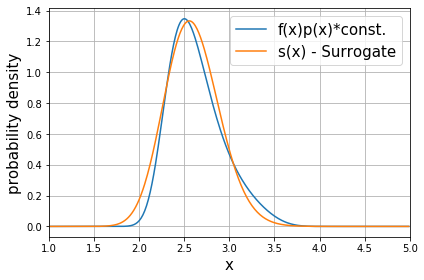

In [5]:
# plot the two density functions:
x_i = np.arange(1, 5, 0.01)
y_i = 10*np.exp(-5*(x_i-3)**4) * (1/(2*pi)**0.5 *np.exp(-0.5*x_i**2))*10.5

# surrogate: # gamma
y_i2 = st.gamma.pdf(x_i, a=74, scale=0.035)

plt.figure()
plt.plot(x_i, y_i, label="f(x)p(x)*const.")
plt.plot(x_i,y_i2, label="s(x) - Surrogate")
plt.xlabel("x", fontsize=15)
plt.ylabel("probability density", fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.xlim([1, 5])
plt.tight_layout()
plt.show()

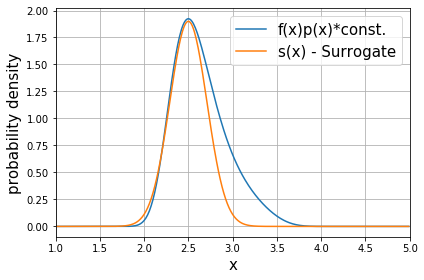

In [6]:
x_i = np.arange(1, 5, 0.01)
y_i = 10*np.exp(-5*(x_i-3)**4) * (1/(2*pi)**0.5 *np.exp(-0.5*x_i**2))*15

# surrogate: # normal
y_i2 = st.norm.pdf(x_i, loc=2.5, scale=0.21)
plt.plot(x_i, y_i, label="f(x)p(x)*const.")
plt.plot(x_i,y_i2, label="s(x) - Surrogate")
plt.xlabel("x", fontsize=15)
plt.ylabel("probability density", fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.xlim([1, 5])
plt.tight_layout()
plt.show()

In [7]:
def getNSamples_surrogate(N):
    # the gamma distribution was determined to be a good surrogate.
    x_i = np.random.gamma(shape = 74, scale=0.035, size=(N))
    y_i = 10*np.exp(-5*(x_i-3)**4) * st.norm.pdf(x_i) / st.gamma.pdf(x_i, a=74, scale=0.035)
    return y_i


np.random.seed(0)
num_samples = 100 
y2 = getNSamples_surrogate(N=num_samples)
MC100_mean2 = np.mean(y2)
MC100_se2 = np.std(y2)/10

print("The approximated integral value using the UPDATED Monte Carlo sampling with 100 samples:", round(MC100_mean2,5) )
print("Standard error:")
print("b)", MC100_se)
print("d)", MC100_se2, "<- noticeably lower. This was expected.")

The approximated integral value using the UPDATED Monte Carlo sampling with 100 samples: 0.08894
Standard error:
b) 0.030407716108832267
d) 0.0019444803264222915 <- noticeably lower. This was expected.


# e)

Approximate the integral using Monte Carlo (100 samples) but instead of using the build-in generator for the standard normal distribution, implement rejection sampling using a logistic distribution-based envelope. Compare the variance of this estimator with the variance of estimator from (b) and discuss.

Number of accepted samples: 83
Mean    : 0.09
Variance: 1.312e-05


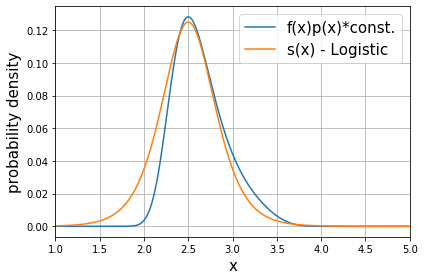

In [8]:
def envelope(x):
    M = 1/10
    return M*st.logistic.pdf(x, loc=2.6, scale=0.2)

np.random.seed(0)
accepted = []
for i in range(100):
    x = st.logistic.rvs(loc=2.5, scale=0.2, size=1)[0]
    u = st.uniform.rvs(loc=0, scale=envelope(x), size=1)[0]
    if (u <= (10*np.exp(-5*(x-3)**4) * (1/(2*pi)**0.5 *np.exp(-0.5*x**2)))):
        accepted.append(x) 

accepted = np.array(accepted)
print("Number of accepted samples:", len(accepted))
vals =  (10*np.exp(-5*(accepted-3)**4) * (1/(2*pi)**0.5 *np.exp(-0.5*accepted**2)))
print("Mean    :", round(np.mean(vals), 3))
print("Variance:", round(np.var(vals)/100, 8))

x_i = np.arange(1, 5, 0.01)
y_i = 10*np.exp(-5*(x_i-3)**4) * (1/(2*pi)**0.5 *np.exp(-0.5*x_i**2))
# surrogate: # logistic
y_i2 = st.logistic.pdf(x_i, loc=2.5, scale=0.2) / 10
plt.plot(x_i, y_i, label="f(x)p(x)*const.")
plt.plot(x_i,y_i2, label="s(x) - Logistic")
plt.xlabel("x", fontsize=15)
plt.ylabel("probability density", fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.xlim([1, 5])
plt.tight_layout()
plt.show()

## f)

Approximate the integral using Monte Carlo (100 samples) but instead of using the build-in generator for the standard normal distribution, implement Metropolis-Hastings with a $U(x_i−\delta,x_i+\delta),\delta>0$ proposal distribution. How do the variance of the estimator and the rejection rate change with  
$\delta$? Find the optimal $\delta$ and compare the optimal variance with (b). What is the effective sample size (ESS)? You may use a library for MCMC variance estimation.

In [9]:
np.random.seed(0)

def proposal_dist(x, delta):
    return st.uniform.rvs(loc=x-delta, scale=2*delta, size=1)[0]

deltas = np.arange(0.1, 10.1, 0.1)
N = 100

rejections = []
integrals = []
variances = []
ess_vals = []

for d in deltas:
    x = 2.5
    samples = []
    reject_count = 0
    for k in range(N):
        x_ = np.array(proposal_dist(x, d))
        u_ = np.random.random(1)
        if u_ <= min(1, f(x_)/f(x)):
            x = x_
        else:
            reject_count += 1
        samples.append(x)
    
    samples = np.array(samples)
    rejections.append( reject_count / N )
    ess_vals.append(az.ess(np.array(samples)))
    f_vals = f(samples)
    integrals.append(np.mean(f_vals))
    variances.append(np.var(f_vals)/100)


best_id = np.argmax(ess_vals)
best_d = deltas[best_id]
best_variance = round(variances[best_id], 5)
best_integral = round(integrals[best_id], 5)
best_ess = round(ess_vals[best_id], 5)

print("best id:", best_id)
print("optimal delta:", best_d)
print("optimal_variance:", best_variance)
print("optimal_integral:", best_integral)
print("optimal rejection rate:", rejections[best_id])
print("ESS:", best_ess)

best id: 9
optimal delta: 1.0
optimal_variance: 1e-05
optimal_integral: 0.09899
optimal rejection rate: 0.59
ESS: 52.30325


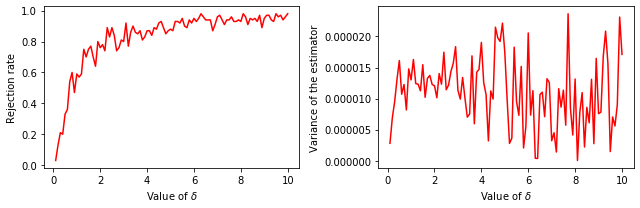

In [10]:
plt.figure(figsize=(9,3))
plt.subplot(1, 2, 1)
plt.plot(deltas, rejections, color="red")
plt.xlabel(r'Value of $\delta$')
plt.ylabel(r'Rejection rate')
plt.subplot(1, 2, 2)
plt.plot(deltas, variances, color="red")
plt.xlabel(r'Value of $\delta$')
plt.ylabel(r'Variance of the estimator')
plt.yticks(ticks=[0, 5E-6, 10E-6, 15E-6, 20E-6 ])
plt.tight_layout()
plt.show()

------------------------------

## Exercise 4.2 (Properties of Markov Chains)

### b) 
$$
K = \begin{bmatrix}
\frac{1}{10} & \frac{2}{10} & \frac{3}{10} & \frac{4}{10} \\[0.1em]
0 & \frac{5}{10} & \frac{2}{10} & \frac{3}{10} \\[0.1em]
0 & 0 & \frac{3}{10} & \frac{7}{10} \\[0.1em]
0 & 0 & \frac{1}{10} & \frac{9}{10} 
\end{bmatrix}.
$$

K^100:
[[1.00000000e-101 1.97215226e-031 1.25000000e-001 8.75000000e-001]
 [0.00000000e+000 3.94430453e-031 1.25000000e-001 8.75000000e-001]
 [0.00000000e+000 0.00000000e+000 1.25000000e-001 8.75000000e-001]
 [0.00000000e+000 0.00000000e+000 1.25000000e-001 8.75000000e-001]]

Stationary distribution: [0.    0.    0.125 0.875]

Drawing of the graph without the self recursive loops:


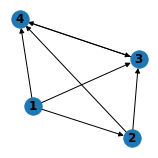

In [11]:
K1   =   np.array([[0.1, 0.2, 0.3, 0.4],
                   [  0, 0.5, 0.2, 0.3],
                   [  0,   0, 0.3, 0.7],
                   [  0,   0, 0.1, 0.9]])
prod = K1
for i in range(100):
    prod = np.matmul(prod.copy(), K1) # brute force approach to finding the stationary distribution.
print("K^100:\n" + str(prod) + "\n")

v = np.array([0,0,1/8, 7/8])
print( "Stationary distribution:", np.matmul(v, K1) )

print("\nDrawing of the graph without the self recursive loops:")
DG = nx.DiGraph()
DG.add_weighted_edges_from([(1, 1, 0.1), (1, 2, 0.2), (1, 3, 0.3), (1, 4, 0.4), (2, 2, 0.5), (2, 3, 0.2), (2, 4, 0.3),
                            (3, 3, 0.3), (3, 4, 0.7), (4, 3, 0.1), (4, 4, 0.9)])
plt.figure(figsize=(2,2))
nx.draw(DG, with_labels=True, font_weight='bold')
plt.show()

### c) 
$$
K = \begin{bmatrix}
1 & 0 & 0 & 0 \\[0.1em]
0 & \frac{1}{2} & \frac{1}{2} & 0 \\[0.1em]
0 & \frac{1}{2} & \frac{1}{2} & 0 \\[0.1em]
\frac{1}{2} & 0 & 0 & \frac{1}{2} 
\end{bmatrix}.
$$

K^100:
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01 5.00000000e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01 5.00000000e-01 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 3.94430453e-31]]

Stationary distribution 1: [0.  0.5 0.5 0. ]
Stationary distribution 2: [1. 0. 0. 0.]

Drawing of the graph without the self recursive loops::


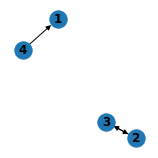

In [32]:
K2   =   np.array([[   1,   0,   0,   0],
                   [   0, 0.5, 0.5,   0],
                   [   0, 0.5, 0.5,   0],
                   [ 0.5,   0,   0, 0.5]])
prod = K2
for i in range(100):
    prod = np.matmul(prod.copy(), K2) # brute force approach to finding the stationary distribution.
print("K^100:\n" + str(prod) + "\n")

v1 = np.array([0, 1/2, 1/2, 0])
print( "Stationary distribution 1:", np.matmul(v1, K2) )

v2 = np.array([1, 0, 0, 0])
print( "Stationary distribution 2:", np.matmul(v2, K2) )

print("\nDrawing of the graph without the self recursive loops::")
DG = nx.DiGraph()
DG.add_weighted_edges_from([(1, 1, 1), (2, 2, 0.5), (2, 3, 0.5), (3, 2, 0.5), (3, 3, 0.5), (4, 1, 0.5), (4, 4, 0.5)])
plt.figure(figsize=(2,2))
nx.draw(DG, with_labels=True, font_weight='bold')
plt.show()

The solutions to d) and e) parts are explained in the main report jn2279.pdf.

------------------------------------------------------

# Exercise 5.1 (Bayesian inference for logistic regression)

## a) Generate a toy dataset

In [13]:
def get_toy_data(N, seed=0):
    np.random.seed(seed)
    X = np.random.normal(loc=0.0, scale=1.0, size=(N, 5))
    X = np.c_[ np.ones((N, 1)), X ] # add a column of ones.
    g = np.array([3*X[:,1]-2*X[:,2] + 0.1*X[:,3] + 1]).T
    Y = ((1/(1+np.exp(-g))) >= np.random.random((N,1)))*1
    return X, Y

# generate toy data:
X, y = get_toy_data(N=100, seed=0)

## b) 
Implement the logistic regression likelihood with an arbitrary number of coefficients and combine it with a weakly-informative standard normal prior to get a function that is proportional to the posterior distribution of the logistic regression model.

We implement likelihood, by first implementing log-likelihood because summation is better.

In [14]:
def log_likelihood(X, y, beta):
    y = y.reshape((-1,1))
    beta = beta.reshape((-1,1))
    eXbeta = np.exp(np.matmul(X, beta))
    i_logit = eXbeta/(1+eXbeta)
    eps = 0.0000001
    return np.sum((1-y)*np.log(1-i_logit+eps) + y*np.log(i_logit+eps))

def normal_log_prior(beta):
    return np.sum(st.norm.logpdf(beta, loc=0, scale=100))

def log_posterior(X, y, beta):
    return log_likelihood(X, y, beta) + normal_log_prior(beta)


beta = np.array([[1, 1, -2, 0.1, 0, 0]]).T
log_posterior(X, y, beta)

-72.76296477048953

In [15]:
def M_H(posterior, X, y, n, beta_init, seed=0):
    np.random.seed(seed)
    cols = X.shape[1]
    beta_indexes = np.array([k for k in range(cols)])
    rejections = np.array([0 for k in range(cols)])
    betas = np.array(np.repeat(beta_init, n+1)).reshape((cols, n+1))
    
    for i in range(1, n+1):
        np.random.shuffle(beta_indexes)
        for j in beta_indexes:
            new_beta_j = betas[j, i-1]+st.norm.rvs(loc=0.0, scale=1.0, size=1)
            old_beta = betas[:, i-1].reshape((-1,1))
            new_beta = np.copy(old_beta)
            new_beta[j, 0] = new_beta_j[0]
            
            log_p_new = posterior(X, y, new_beta)
            log_p_previous = posterior(X, y, old_beta)
            
            log_r = log_p_new - log_p_previous
            
            if (np.log(np.random.random())) < log_r:
                betas[j, i] = new_beta_j
            else:
                betas[j,i] = betas[j, i-1]
                rejections[j] = rejections[j]+1
            
        
    return betas , rejections

Number of rejected samples for parameter beta_0: 5695
ESS for parameter beta_0: 445.07732518218967
Number of rejected samples for parameter beta_1: 4279
ESS for parameter beta_1: 316.1432929795815
Number of rejected samples for parameter beta_2: 5304
ESS for parameter beta_2: 333.1651989358037
Number of rejected samples for parameter beta_3: 6042
ESS for parameter beta_3: 1895.494335323633
Number of rejected samples for parameter beta_4: 5643
ESS for parameter beta_4: 1858.4409482762917
Number of rejected samples for parameter beta_5: 4972
ESS for parameter beta_5: 913.6451163280753

Number of rejected samples for parameter beta_0: 5724
ESS for parameter beta_0: 568.0632312774454
Number of rejected samples for parameter beta_1: 4463
ESS for parameter beta_1: 424.0993164912084
Number of rejected samples for parameter beta_2: 5280
ESS for parameter beta_2: 512.368896646835
Number of rejected samples for parameter beta_3: 6061
ESS for parameter beta_3: 1664.096891079755
Number of rejected

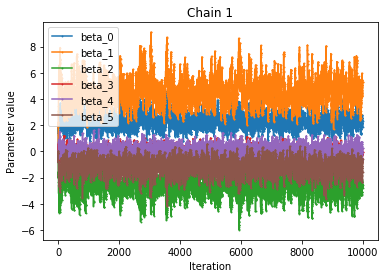

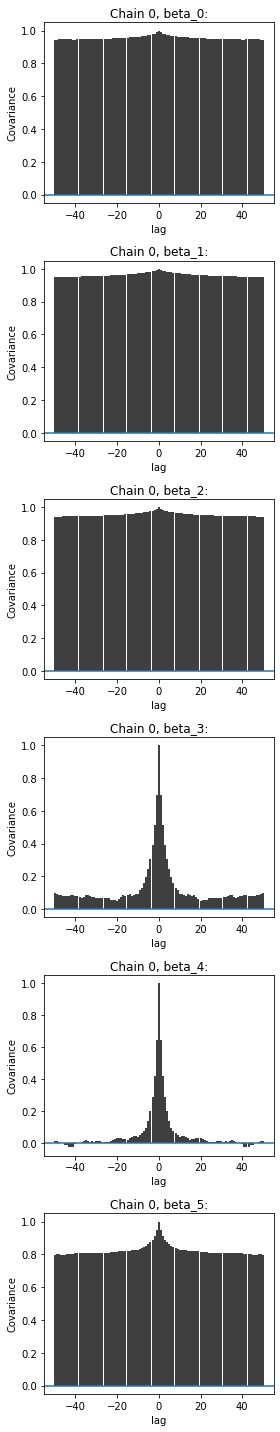

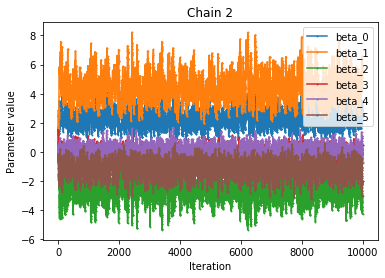

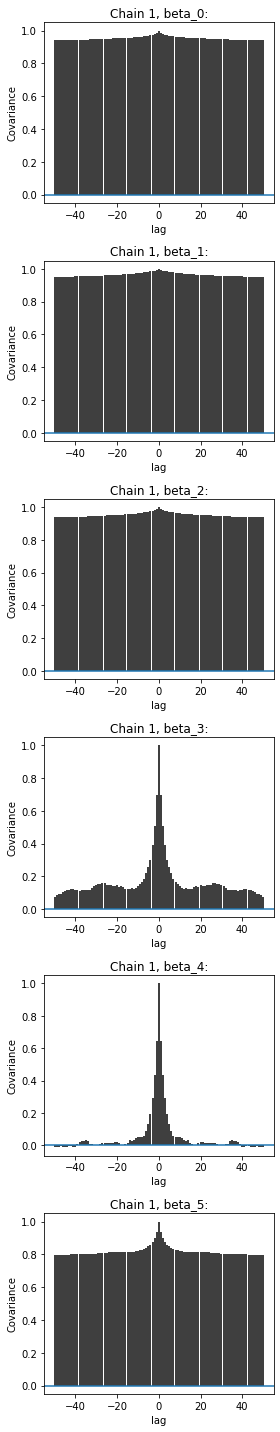

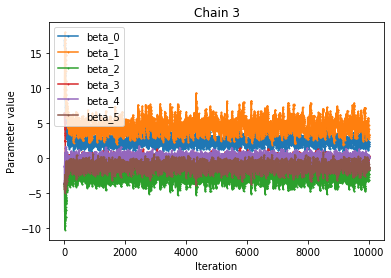

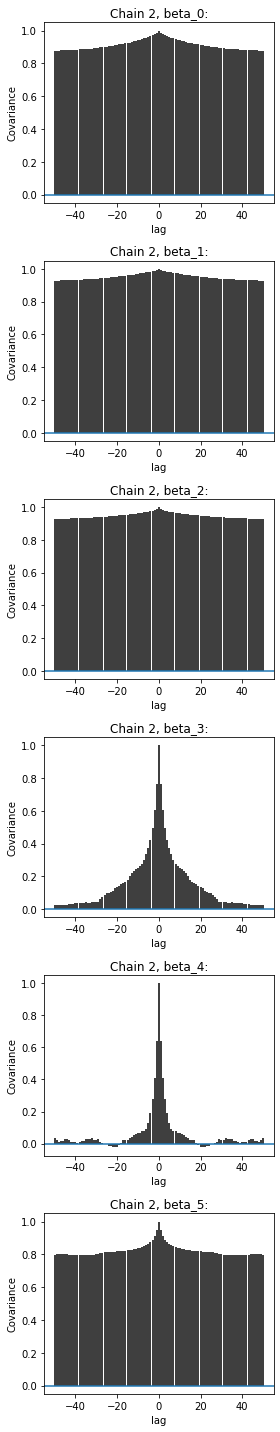

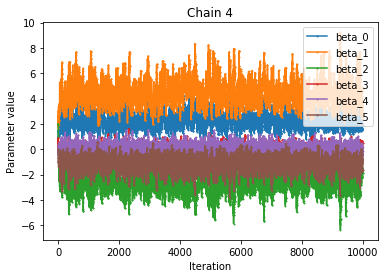

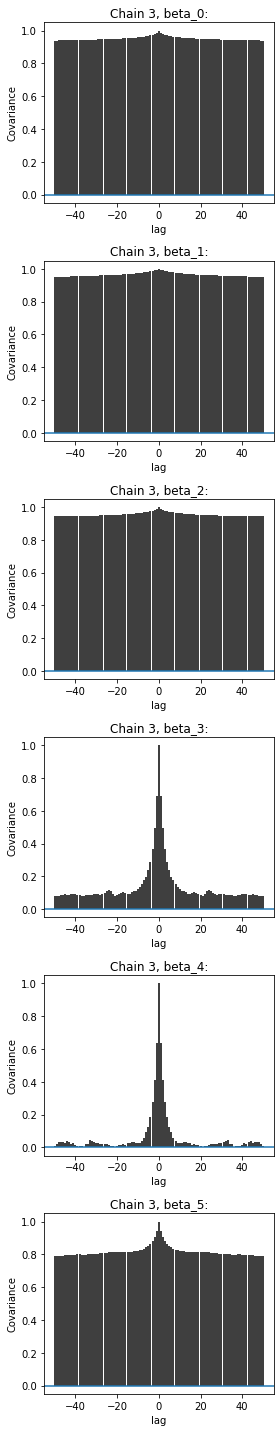

In [16]:
np.random.seed(42)
beta_init_1 = np.array([0]*6, dtype=np.float32)
beta_init_2 = np.array(np.random.normal(0, 1, size=(6,)), dtype=np.float32)
beta_init_3 = np.array(np.random.normal(1, 10, size=(6,)), dtype=np.float32)
beta_init_4 = np.array([1, 3, 2, 0.1, 0, 0], dtype=np.float32)
betas, rejections = None, None
for i, beta_init in enumerate([beta_init_1, beta_init_2, beta_init_3,  beta_init_4]):
    betas, rejections = M_H(log_posterior, X, y, 10000, beta_init, i*1000)
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots(6,1, figsize=(4, 20))
    for j in range(len(rejections)):
        ax.plot(range(len(betas[j,:])), betas[j,:], 'o-', label=f'beta_{j}', markersize=0.9)
        print(f'Number of rejected samples for parameter beta_{j}: {rejections[j]}')
        print(f'ESS for parameter beta_{j}:', az.ess(betas[j,:]))
        ax2[j].set_ylabel('Covariance')
        ax2[j].set_title(f'Chain {i}, beta_{j}:')
        ax2[j].acorr(betas[j, :], maxlags=50)
        ax2[j].set_xlabel('lag')
        
    if i == 0:
        betas_special = betas
    fig2.tight_layout()
    print()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Parameter value")
    ax.set_title("Chain "+str(i+1))
    ax.legend()

Do your best to improve the efficiency of the sampler by changing the covariance matrix of the proposal distribution. Report the rejection rate and ESS for the most efficient M-H sampler you get. Compare with those obtained in (3) and discuss.

[[160   0   0   0   0   0]
 [  0 160   0   0   0   0]
 [  0   0 160   0   0   0]
 [  0   0   0 160   0   0]
 [  0   0   0   0 160   0]
 [  0   0   0   0   0 160]]
Number of rejected samples for parameter beta_0: 5806
ESS for parameter beta_0: 488.78523243551484
Number of rejected samples for parameter beta_1: 4545
ESS for parameter beta_1: 313.33032022010883
Number of rejected samples for parameter beta_2: 5504
ESS for parameter beta_2: 396.9461440957188
Number of rejected samples for parameter beta_3: 6109
ESS for parameter beta_3: 1927.644934376639
Number of rejected samples for parameter beta_4: 5791
ESS for parameter beta_4: 1961.7401931303348
Number of rejected samples for parameter beta_5: 5037
ESS for parameter beta_5: 1162.784301279014

Number of rejected samples for parameter beta_0: 5856
ESS for parameter beta_0: 644.1747162982664
Number of rejected samples for parameter beta_1: 4479
ESS for parameter beta_1: 472.4504175418475
Number of rejected samples for parameter beta_2: 

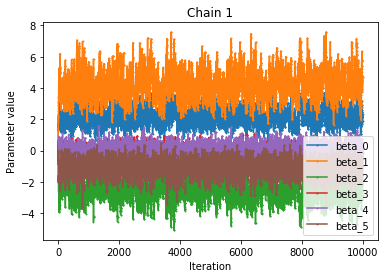

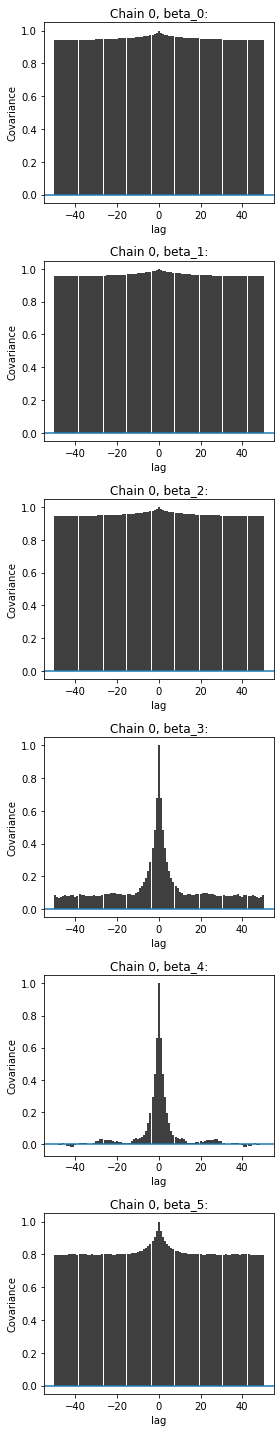

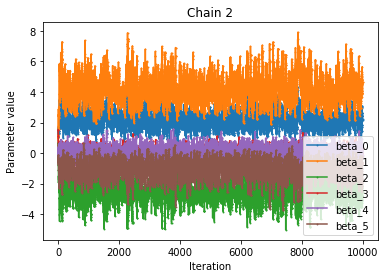

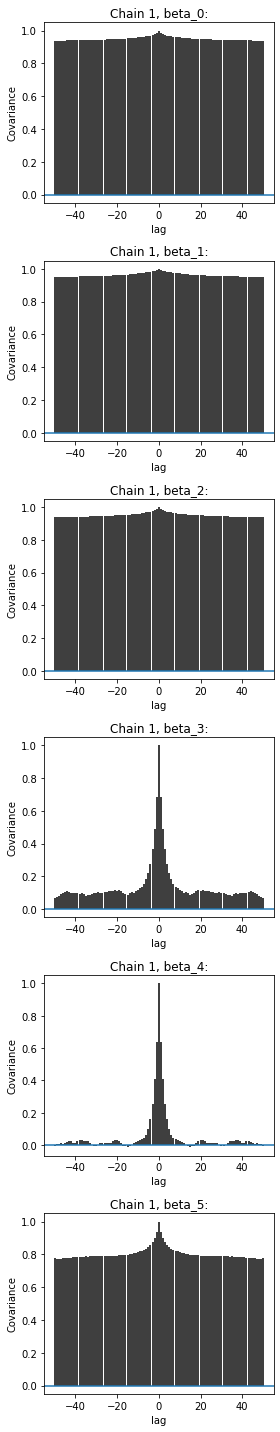

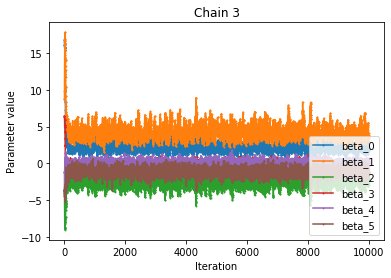

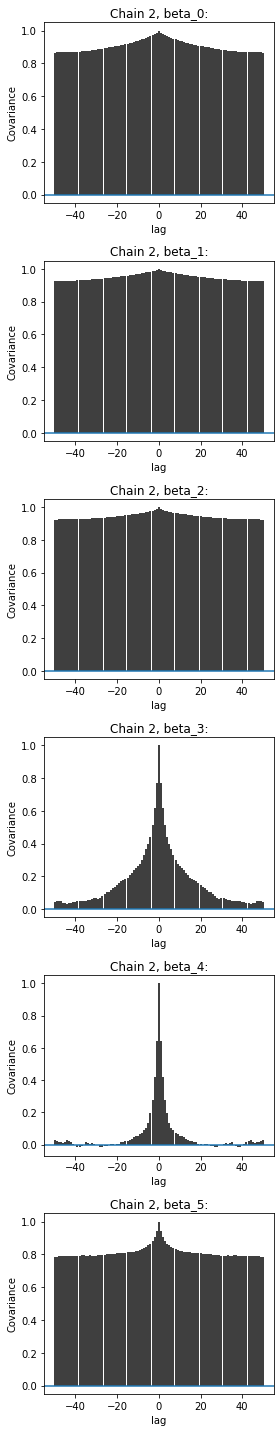

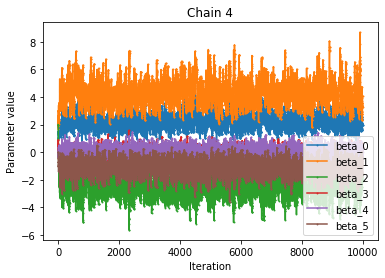

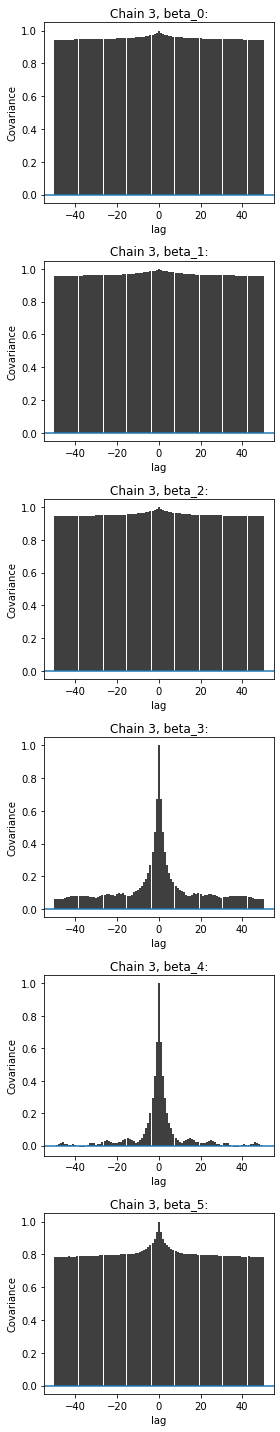

In [17]:
def normal_log_prior_2(beta, covariance):
    return np.sum(st.multivariate_normal.logpdf(beta, cov=covariance))

def log_posterior_2(X, y, beta):
    return log_likelihood(X, y, beta) + normal_log_prior_2(beta, cov)

np.random.seed(42)
beta_init_1 = np.array([0]*6, dtype=np.float32)
beta_init_2 = np.array(np.random.normal(0, 1, size=(6,)), dtype=np.float32)
beta_init_3 = np.array(np.random.normal(1, 10, size=(6,)), dtype=np.float32)
beta_init_4 = np.array([1, 3, 2, 0.1, 0, 0], dtype=np.float32)


betas2, rejections = None, None
cov   = np.array([[160, 0, 0, 0, 0, 0],
                  [0, 160, 0, 0, 0, 0], 
                  [0, 0, 160, 0, 0, 0], 
                  [0, 0, 0, 160, 0, 0], 
                  [0, 0, 0, 0, 160, 0], 
                  [0, 0, 0, 0, 0, 160]])
print(cov)
for i, beta_init in enumerate([beta_init_1, beta_init_2, beta_init_3, beta_init_4]):
    betas2, rejections = M_H(log_posterior_2, X, y, 10000, beta_init, i*1000)
    fig, ax = plt.subplots()
    fig2, ax2 = plt.subplots(6,1, figsize=(4, 20))
    for j in range(len(rejections)):
        ax.plot(range(len(betas2[j,:])), betas2[j,:], 'o-', label=f'beta_{j}', markersize=0.9)
        
        print(f'Number of rejected samples for parameter beta_{j}: {rejections[j]}')
        print(f'ESS for parameter beta_{j}:', az.ess(betas2[j,:]))
        ax2[j].set_ylabel('Covariance')
        ax2[j].set_title(f'Chain {i}, beta_{j}:')
        ax2[j].acorr(betas2[j, :], maxlags=50)
        ax2[j].set_xlabel('lag')
        
    if i == 0:
        betas2_special = betas2
    fig2.tight_layout()
    print()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Parameter value")
    ax.set_title("Chain "+str(i+1))
    ax.legend(loc='lower right')

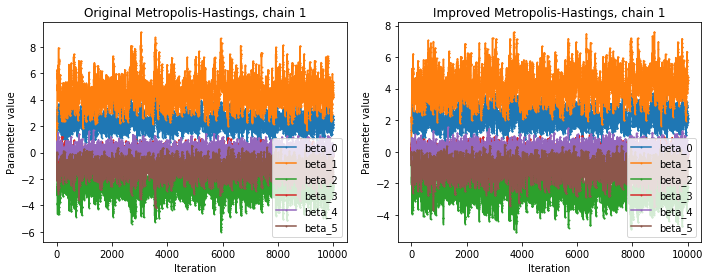

In [18]:
# plot merged:
# %matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(10, 4))
for j in range(6):
    ax[0].plot(range(len(betas_special[j,:] )), betas_special[j,:] , 'o-', label=f'beta_{j}', markersize=0.9)
    ax[1].plot(range(len(betas2_special[j,:])), betas2_special[j,:], 'o-', label=f'beta_{j}', markersize=0.9)
    ax[0].set_xlabel("Iteration")
    ax[1].set_xlabel("Iteration")
    ax[0].set_ylabel("Parameter value")
    ax[1].set_ylabel("Parameter value")
    ax[0].set_title("Original Metropolis-Hastings, chain 1")
    ax[1].set_title("Improved Metropolis-Hastings, chain 1")
    ax[0].legend(loc='lower right')
    ax[1].legend(loc='lower right')
fig.tight_layout()
plt.show()

Estimate posterior means of $\beta_i$ using the most efficient sampler. Compare with the ground truth and a MLE fit of logistic regression (you may use a third party library for the GLM). Estimate the posterior probability 
$P(|\beta_3|>\frac{1}{10}|\text{data})$.

In [19]:
print(np.mean(betas[:,-5000:], axis=1))

[ 2.2427065   4.4253073  -2.7042634  -0.10183653  0.02778161 -1.1589944 ]


Compare with the ground truth and a MLE fit of logistic regression (you may use a third party library for the GLM)

In [20]:
clf = LogisticRegression(random_state=0).fit(X, y[:,0])
print( clf.coef_ )

[[ 9.18047767e-06  2.35114235e+00 -1.49888421e+00 -4.53946976e-02
  -1.79909991e-02 -6.03549364e-01]]


Estimate the posterior probability $P(|\beta_3|>\frac{1}{10}|\text{data})$

In [21]:
print(np.mean((np.abs(betas[3,-5000:]) > 1/10)*1)) # beta_3 is at fourth place!

0.803


----------------------

# Exercise 5.2 (Tuning the M-H sampler for the Banana function)

Plot a contour plot of this function (it should look like a banana):
$$
f_n\left( x \right) = e^{-\frac{x\left[1\right]^2}{200}
    -\frac{1}{2}\left( x\left[2\right] + 0.05\cdot x\left[1\right]^2 - 100\cdot 0.05\right)^2}.
$$

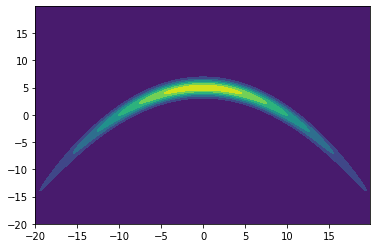

In [22]:
def fn(x): 
    xTo2 = x[0]**2
    return np.exp(-0.005*xTo2 -0.5*(x[1]+0.05*xTo2-5)**2)
bound = 20
x = np.arange(-bound, bound, 0.1)
y = x.copy()
f = fn((np.meshgrid(x,y)))

fig = plt.contourf(x,y,f)
# plt.scatter([-15],[-7], color="red")
fig.changed()

In [23]:
def proposal_dist(x, delta):
    return np.array([st.uniform.rvs(loc=x[0]-delta/2, scale=delta, size=1)[0],
                     st.uniform.rvs(loc=x[1]-delta/2, scale=delta, size=1)[0]])

np.random.seed(2)
N = 1000
delta = 1

start_points = [np.array([0, 5 ]), np.array([10, -5 ]), np.array([-15, -7])]
samples_list = []
rejected_list = []
for start_point in start_points:
    x = start_point.copy()
    samples = np.array([[start_point[0], start_point[1]]])
    rejected = []
    for k in range(N):
        x_ = np.array(proposal_dist(x, delta))
        u_ = np.random.random(size=1)
        if u_ <= min(1, fn(x_)/fn(x)):
            x = x_
            rejected.append(0)
        else:
            rejected.append(1)
        samples = np.r_[samples, x.reshape((1,2))]
    samples_list.append(samples[1:,:])
    rejected_list.append(rejected)
    
    
rejections_fracs = [np.mean(rejected) for rejected in rejected_list]
ess_vals_x = []
ess_vals_y = []
for samples in samples_list:
    ess_vals_x.append(az.ess(samples[:,0]))
    ess_vals_y.append(az.ess(samples[:,1]))
print("Fraction of rejections:", rejections_fracs)
print( ess_vals_x )
print( ess_vals_y )

Fraction of rejections: [0.085, 0.107, 0.189]
[1.8177640212882569, 1.3310658584729917, 2.098546370325094]
[2.5026453113383296, 1.3730968917993158, 2.150122700668538]


In [24]:
np.random.seed(2)
N = 1000
delta = 20

start_points2 = [np.array([0, 5 ]), np.array([10, -5 ]), np.array([-15, -7])]
samples_list2 = []
rejected_list2 = []
for start_point2 in start_points2:
    x = start_point2.copy()
    samples2 = np.array([[start_point2[0], start_point2[1]]])
    rejected2 = []
    for k in range(N):
        x_ = np.array(proposal_dist(x, delta))
        u_ = np.random.random(size=1)
        if u_ <= min(1, fn(x_)/fn(x)):
            x = x_
            rejected2.append(0)
        else:
            rejected2.append(1)
        samples2 = np.r_[samples2, x.reshape((1,2))]
    samples_list2.append(samples2[1:,:])
    rejected_list2.append(rejected2)
    
    
rejections_fracs2 = [np.mean(rejected2) for rejected2 in rejected_list2]
ess_vals_x2 = []
ess_vals_y2 = []
for samples2 in samples_list2:
    ess_vals_x2.append(az.ess(samples2[:,0]))
    ess_vals_y2.append(az.ess(samples2[:,1]))
print("Fraction of rejections:", rejections_fracs2)
print( ess_vals_x2 )
print( ess_vals_y2 )

Fraction of rejections: [0.874, 0.841, 0.892]
[8.7913091014947, 21.243914788953894, 1.715548029634335]
[36.875912866798494, 76.84200440249155, 3.6758916921376428]


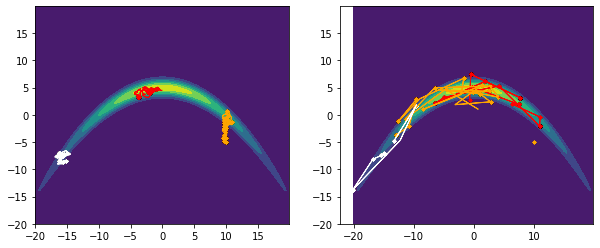

In [25]:
# plot the first 100 steps.
# %matplotlib inline
# plots:
bound = 20
x = np.arange(-bound, bound, 0.1)
y = x.copy()
f = fn((np.meshgrid(x,y)))
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
fig = plt.contourf(x,y,f)
colours = ["red", "orange", "white"]

for i in range(3):
    samples  = samples_list[i][:100,:]
    rejected = np.array(rejected_list[i][:100])==np.ones((100))
    sum_rejected = np.sum(rejected)
    # print(sum_rejected)
    accepted_samples = samples[~rejected,:]
    rejected_samples = samples[rejected,:]
    # print( accepted_samples.shape )
    # print( rejected_samples.shape )
    col = colours[i]
    for j in range(accepted_samples.shape[0]-1):
        x_start = accepted_samples[j,0]
        y_start = accepted_samples[j,1]
        x_diff  = accepted_samples[j+1,0] - x_start 
        y_diff  = accepted_samples[j+1,1] - y_start
        plt.arrow(x_start, y_start, x_diff, y_diff, width=0.001, head_width=0.005,  color=col)
        plt.scatter(rejected_samples[:,0], rejected_samples[:,1], color=col, s=5)
fig.changed()

# ------------------------------------------------------------------------------

# plot the first 100 steps.
bound = 20
x = np.arange(-bound, bound, 0.1)
y = x.copy()
f = fn((np.meshgrid(x,y)))
plt.subplot(1, 2, 2)
fig = plt.contourf(x,y,f)
colours = ["red", "orange", "white"]

for i in range(3):
    samples2  = samples_list2[i][:100,:]
    rejected2 = np.array(rejected_list2[i][:100])==np.ones((100))
    sum_rejected2 = np.sum(rejected2)
    accepted_samples2 = samples2[~rejected2,:]
    rejected_samples2 = samples2[rejected2,:]
    col = colours[i]
    for j in range(accepted_samples2.shape[0]-1):
        x_start2 = accepted_samples2[j,0]
        y_start2 = accepted_samples2[j,1]
        x_diff2  = accepted_samples2[j+1,0] - x_start2
        y_diff2  = accepted_samples2[j+1,1] - y_start2
        plt.arrow(x_start2, y_start2, x_diff2, y_diff2, width=0.001, head_width=0.005,  color=col)
        plt.scatter(rejected_samples2[:,0], rejected_samples2[:,1], color=col, s=5)
    
fig.changed()

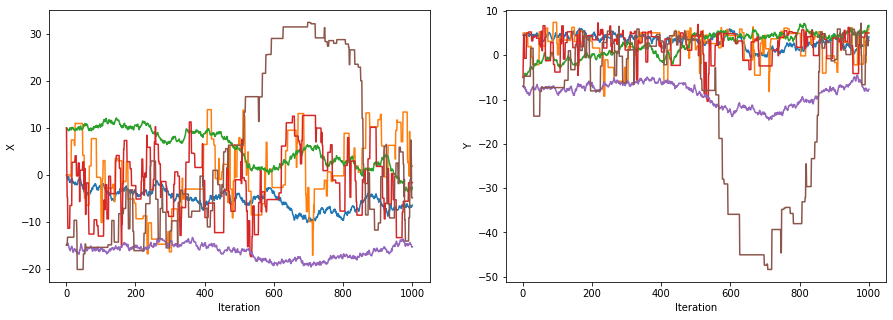

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
for i, samples in enumerate(samples_list):
    samples2 = samples_list2[i]
    plt.plot(np.arange(1, 1001), samples[:,0])
    plt.plot(np.arange(1, 1001), samples2[:,0])
    plt.xlabel("Iteration")
    plt.ylabel("X")
    
plt.subplot(1,2,2)
for i, samples in enumerate(samples_list):
    samples2 = samples_list2[i]
    plt.plot(np.arange(1, 1001), samples[:,1])
    plt.plot(np.arange(1, 1001), samples2[:,1])
    plt.xlabel("Iteration")
    plt.ylabel("Y")
plt.show()

(400, 400)


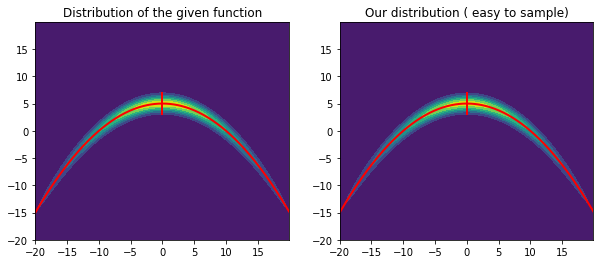

In [27]:
# alternative:
%matplotlib inline

def alt_f(x_vec):
    x_vec[1] -= (-0.05*x_vec[0]**2+5)
    val = st.multivariate_normal.pdf(x=x_vec, mean=np.array([0,0]), cov = np.array([[97,0],[0,1]]) ) # + (-0.05*x**2+5)
    
    return val

f2 = lambda x: -0.05*x**2+5

# fn_alt = lambda x, y: st.multivariate_normal.pdf(x=x, mean=np.array([0,0]), cov = np.array([[1,0],[0,1]]) ) +5

bound = 20
x = np.arange(-bound, bound, 0.1)
y2= f2(x)
y = x.copy()
field = fn(np.meshgrid(x,y))
field_prev = field.copy()
print(field.shape)
for i in range(len(x)):
    for j in range(len(x)):
        field[j, i] = alt_f(np.array([x[i],y[j]]))

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
f = fn((np.meshgrid(x,y)))
fig = plt.contourf(x,y,f)
plt.plot([0,0], [3,7], color="red", linewidth=2)
plt.plot(x, y2, color="red", linewidth=2)
plt.title("Distribution of the given function")
fig.changed()

plt.subplot(1,2,2)
fig = plt.contourf(x,y,field)
plt.plot([0,0], [3,7], color="red", linewidth=2)
plt.plot(x, y2, color="red", linewidth=2)
plt.title("Our distribution ( easy to sample)")
fig.changed()

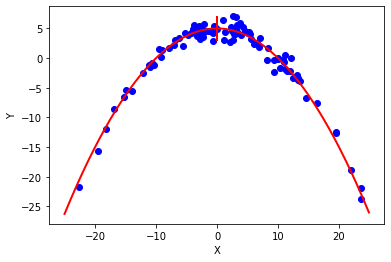

In [28]:
rez = st.multivariate_normal.rvs(mean=np.array([0,0]), cov = np.array([[97,0],[0,1]]), size=100, random_state=10 )
x_vec = rez.copy()
x_vec[:,1] += (-0.05*x_vec[:, 0]**2+5)

bound = 25
x = np.arange(-bound, bound, 0.1)
y2 = f2(x)

plt.figure(3)
plt.scatter(x_vec[:,0], x_vec[:,1], color="blue")
plt.plot([0,0], [3,7], color="red", linewidth=2)
plt.plot(x, y2, color="red", linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")
fig.changed()

In [29]:
az.ess(np.array(x_vec.T))

238.6701075514937

In [30]:
rez = st.multivariate_normal.rvs(mean=np.array([0,0]), cov = np.array([[97,0],[0,1]]), size=100, random_state=10 )
x_vec = rez.copy()
x_vec[:,1] += (-0.05*x_vec[:, 0]**2+5)
az.ess(x_vec.T)

238.6701075514937